# Exercise 2 | TKO_7092 Evaluation of Machine Learning Methods 2025


## Water permeability prediction in forestry <br>

In this task, the client wants you to estimate the spatial prediction performance of K-nearest neighbor regression model with K=7 (7NN), using spatial leave-one-out cross-validation (i.e. SKCV, with number of folds == number of data points). The client wants you to use the C-index as the performance measure.  

In other words, the client wants you to answer the question: "What happens to the prediction performance of water permeability using 7-nearest neighbor regression model, when the geographical distance between known data and unknown data increases?".

In this task, you have three data files available (with 1691 data points): 

- input.csv, contains the 75 predictor features. 
- output.csv, contains the water permebility values. 
- coordinates.csv, contains the corresponding geographical coordinate locations of the data points. The unit of the coordinates is metre, and you can use Euclidean distance to calculate distances between the coordinate points. 

Implement the following tasks to complete this exercise:

********************************************

#### 1. Z-score standardize the predictor features (input.csv). 

#### 2. Perform spatial leave-one-out cross-validation with 7NN model for the provided data set (refer to the lectures 3.1.3 and 3.1.4 in 'Evaluating spatial models with spatial cross-validation' for help). Estimate the water permeability prediction performance (using 7NN model and C-index) with the following distance parameter values: d = 0, 20, 40, ..., 300 (that is, 20 meter intervals from 0m to 300m). 

#### 3. When you have calculated the C-index performance measure for each value of d, visualize the results with the C-index (y-axis) as a function of d (x-axis).



### Import necessary libraries

In [1]:
# In this cell, import all the libraries that you need. For example: 

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsRegressor

import matplotlib.pyplot as plt

### Read in the datasets

In [2]:
# In this cell, read the files input.csv, output.csv and coordinates.csv.
# Print out the dataset dimesions (i.e. number of rows and columns).

# Read the CSV file
input = pd.read_csv('input.xls')
output = pd.read_csv('output.xls')
coord =  pd.read_csv('coordinates.xls')

# Print dataset dimensions
print(f"Input dataset dimensions: {input.shape[0]} rows, {input.shape[1]} columns")
print(f"Output dataset dimensions: {output.shape[0]} rows, {output.shape[1]} columns")
print(f"Coordinates dataset dimensions: {coord.shape[0]} rows, {coord.shape[1]} columns")


Input dataset dimensions: 1690 rows, 75 columns
Output dataset dimensions: 1690 rows, 1 columns
Coordinates dataset dimensions: 1690 rows, 2 columns


### Standardization of the predictor features (input.csv)

I used the insturctions and examples found in this website: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
StandardScaler: Standardize features by removing the mean and scaling to unit variance.

In [3]:
# Standardize the predictor features (input.csv) by removing the mean and scaling to unit variance. 
# In other words, z-score the predictor features. You are allowed to use third-party libraries for doing this. 

### Code - Standardization
# Initialize the scaler
scaler = StandardScaler()
standardized_data = scaler.fit_transform(input)

standardized_data

array([[-0.63194304, -0.68274158, -0.28531684, ..., -1.48160969,
        -1.08815201, -0.46164481],
       [-0.67481201, -0.59738256, -0.56840374, ...,  0.3497797 ,
         0.13415936, -0.80939967],
       [-0.33186031, -0.15473506,  1.30704699, ...,  0.46703714,
         0.10690371, -0.83301234],
       ...,
       [ 0.47193274,  0.67080864,  0.10392765, ...,  2.18344348,
         3.52644034,  2.25811122],
       [-0.74983269, -0.733957  , -1.62997963, ...,  1.28859736,
         4.41120089, 11.2554784 ],
       [-0.5676396 , -0.41812861, -1.13457755, ...,  0.51513628,
         5.56432483, 12.95143482]])

### Functions and analysis code

In [4]:
# Include here all the functions and other relevant code that you need in order to implement the task.

# Note! Utilize the following two functions in your implementation:

### Function for calculating C-index ###
# y: array containing true label values.
# yp: array containing the predicted label values.
def cindex(y, yp):
    n = 0
    h_num = 0 
    for i in range(0, len(y)):
        t = y[i]
        p = yp[i]
        for j in range(i+1, len(y)):
            nt = y[j]
            np = yp[j]
            if (t != nt): 
                n = n + 1
                if (p < np and t < nt) or (p > np and t > nt): 
                    h_num += 1
                elif (p == np):
                    h_num += 0.5
    return h_num/n


### Function for calculating the pairwise spatial distances between the data points ###
# The function will return a n-by-n matrix of Euclidean distances. For example, the
# distance_matrix element at indices i,j will contain the spatial distance between 
# data point i and j. Note that the element value is 0 always when i==j.
# coordinate_array: n-by-2 array containing the coordinates of the exercise data points.
def cdists(coordinate_array):
    number_of_observations = coordinate_array.shape[0]
    distance_matrix = np.zeros((number_of_observations, number_of_observations))
    for i in range(0, number_of_observations):
        distance_matrix[i, :] = np.sqrt(np.sum((coordinate_array - coordinate_array[i])**2, axis=1))
    return distance_matrix

# The base for this function is extracted from the previous course exercises. 
# Define spatial leave-one-out cross-validation with 7NN
def spatial_loocv_knn(X, y, coords, distance_thresholds):
    c_index_results = {}

    # Compute pairwise spatial distances (for the train-test split)
    spatial_distance_matrix = cdists(coords)
    
    # Compute pairwise distances in the feature space
    input_distance_matrix = cdists(X)

    # Loop over different distance thresholds
    for d in distance_thresholds:
        predicted_permeability = []
        valid_indices = []

        # Iterate over each data point for leave-one-out cross-validation
        # This loop iterates over each data point, treating one sample at a time as the test sample and using the remaining data for training.
        for test_index in range(len(coords)):
            
            # Exclude the test point and and any points inside the spatial threshold
            neighbor_indices = np.where(spatial_distance_matrix[test_index] > d)[0]

            # Ensure we have at least 7 neighbors
            if len(neighbor_indices) >= 7:
                # Select the 7 nearest neighbors within the threshold
                nearest_neighbors = neighbor_indices[np.argsort(input_distance_matrix[test_index][neighbor_indices])[:7]]

                # Predict permeability as the mean of the neighbors' permeability values
                predicted_value = np.mean(y[nearest_neighbors])
                predicted_permeability.append(predicted_value)
                valid_indices.append(test_index)

        # Compute C-index for valid predictions
        if len(valid_indices) > 1:  # Ensure enough samples for evaluation
            c_index_value = cindex(y[valid_indices], np.array(predicted_permeability))
            c_index_results[d] = c_index_value

    return c_index_results

### Results for spatial leave-one-out cross-validation with 7-nearest neighbor regression model

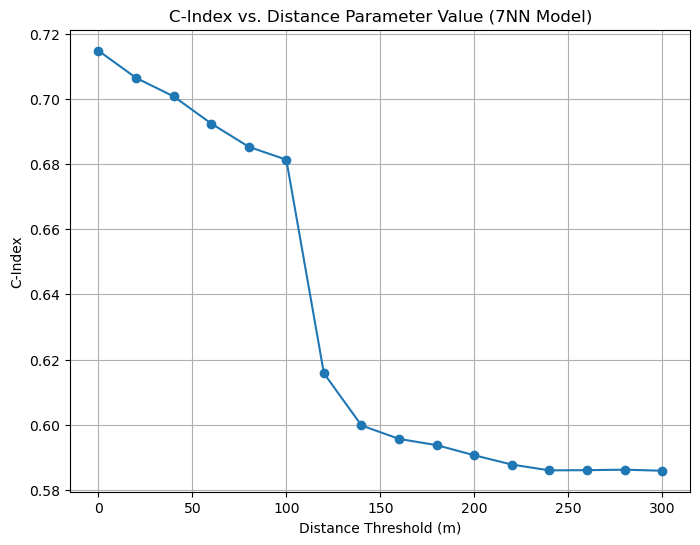

In [5]:
# In this cell, run your script for the Spatial leave-One-Out cross-validation 
# with 7-nearest neighbor regression model and visualize the results as 
# requested in the task assignment.

# Ensure correct parameters
X = standardized_data  # Standardized input features
y = output.iloc[:, 0].values  # Convert target variable to 1D NumPy array
coords = coord.values  # Convert coordinates to NumPy array
distance_thresholds = np.arange(0, 301, 20)  # Distance thresholds from 0m to 300m

# Run spatial leave-one-out cross-validation with 7NN
cindex_results = spatial_loocv_knn(X, y, coords, distance_thresholds)

# Convert results to DataFrame and display
cindex_df = pd.DataFrame(list(cindex_results.items()), columns=["Distance Threshold (m)", "C-Index"])


# Plot C-index vs. Distance Threshold
plt.figure(figsize=(8, 6))
plt.plot(cindex_df["Distance Threshold (m)"], cindex_df["C-Index"], marker='o', linestyle='-')
plt.xlabel("Distance Threshold (m)")
plt.ylabel("C-Index")
plt.title("C-Index vs. Distance Parameter Value (7NN Model)")
plt.grid(True)

# Show the plot
plt.show()

## Analysis of the results

### In this cell, you need to answer the client's questions:


1. What happens to the 7NN performance as the prediction distance increases?


2. Do you think the results behave as was somewhat expected? Do they make sense, why?


3. If we require that the 7NN must have at least C-index performance of 0.68, then up to what distance should we trust the 7NN predictions, based on the results?

1. What happens to the 7NN performance as the prediction distance increases?
As the distance threshold increases, the C-index decreases. This means that the ranking quality of predictions worsens as we allow neighbors from farther distances. The model performs best at lower distances (0m–100m) but its performance declines when the threshold extends beyond 150m.

2. Do you think the results behave as was somewhat expected? Do they make sense, why?
Yes, the results align with expectations. Closer neighbors generally provide more relevant information than farther ones. At small distances (0m–100m), predictions are more accurate because nearby locations tend to have similar permeability values. As the distance increases, we start incorporating neighbors that are farther away and may have less correlation with the test point, leading to a gradual decline in the C-index. This follows real-world spatial dependence principles, where similarity typically decreases with distance.

3. If we require that the 7NN must have at least a C-index performance of 0.68, then up to what distance should we trust the 7NN predictions, based on the results?
From the plot, the C-index remains above 0.68 for distances up to 100m, meaning the model is reliable within this range. However, beyond 100m, the C-index drops below 0.68, indicating that predictions become less trustworthy at greater distances.